# 2024 Project

# NSW Electricity Demand Forecast

## Data Exploration

### Read Data

We use 4 data sources: temperature_nsw.csv (provided by the course), totaldemand_nsw.csv (provided by the course), population_nsw.csv (collected from the [website of Austraian Bureau of Statistics](https://www.abs.gov.au/statistics/people/population/national-state-and-territory-population/dec-2022)) and GDP.csv (collected from the [website of Austraian Bureau of Statistics](https://www.abs.gov.au/statistics/economy/national-accounts/australian-national-accounts-national-income-expenditure-and-product/latest-release#state-and-territory-final-demand)). These datasets encompass crucial variables for our analysis, namely temperature, population, GDP, and energy demand. However, the GDP data reflects the national figure rather than being specific to New South Wales (NSW), as such detailed state-level data was not accessible. To adjust for this, we proceed under the assumption that GDP trends in NSW are representative of the national average, thereby applying the Australia-wide GDP statistics to our NSW-centric forecasting model.

In [5]:
# Import necessary libaraies
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
# Read Temperature file
df_temp_nsw = pd.read_csv('../data/NSW/temperature_nsw.csv')
df_temp_nsw.columns = df_temp_nsw.columns.str.lower()

In [41]:
# Read totaldemand file
df_demand_nsw = pd.read_csv('../data/NSW/totaldemand_nsw.csv')
df_demand_nsw.columns = df_demand_nsw.columns.str.lower()

In [42]:
# Read population file
df_population_nsw = pd.read_csv('../data/NSW/population_nsw.csv')
df_population_nsw.columns = df_population_nsw.columns.str.lower()

In [43]:
# Read GDP file
df_gdp = pd.read_csv('../data/NSW/GDP.csv')
df_gdp.columns = df_gdp.columns.str.lower()

### First glance at the data

In [78]:
df_temp_nsw.head()

,location,datetime,temperature
0,Bankstown,1/1/2010 0:00,23.1
1,Bankstown,1/1/2010 0:01,23.1
2,Bankstown,1/1/2010 0:30,22.9
3,Bankstown,1/1/2010 0:50,22.7
4,Bankstown,1/1/2010 1:00,22.6


In [45]:
df_temp_nsw['location'].nunique()

1

In [46]:
df_demand_nsw.head()

,datetime,totaldemand,regionid
0,1/1/2010 0:00,8038.00,NSW1
1,1/1/2010 0:30,7809.31,NSW1
2,1/1/2010 1:00,7483.69,NSW1
3,1/1/2010 1:30,7117.23,NSW1
4,1/1/2010 2:00,6812.03,NSW1


In [47]:
df_demand_nsw['regionid'].nunique()

1

In [48]:
df_population_nsw.head()

,time,population
0,Dec-2009,7101504
1,Mar-2010,7128356
2,Jun-2010,7144292
3,Sep-2010,7162726
4,Dec-2010,7179891


In [49]:
df_gdp.head()

,time,gdp
0,Dec-2009,334934
1,Mar-2010,314838
2,Jun-2010,340575
3,Sep-2010,345512
4,Dec-2010,365403


### Check Correlation between demand and each variables

#### Temperature and Demand

In [52]:
df_temp_demand_nsw = pd.merge(df_temp_nsw, df_demand_nsw, on='datetime')

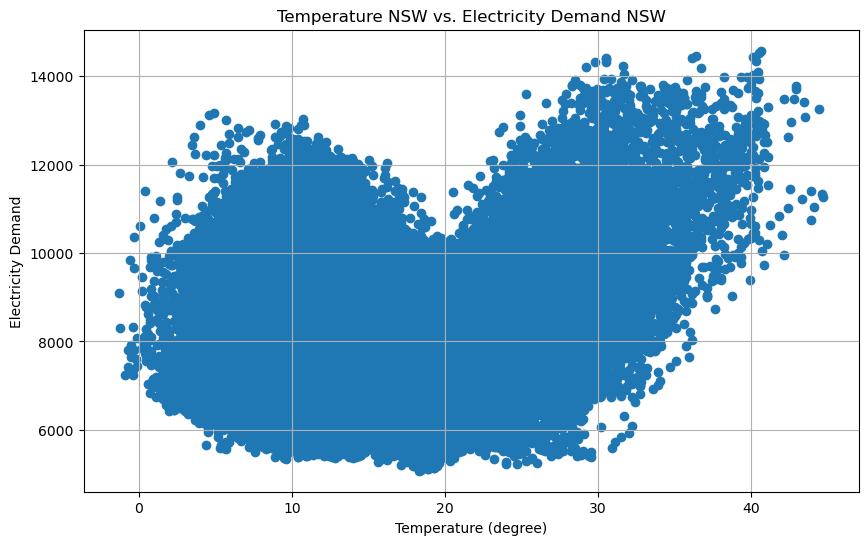

In [53]:
plt.figure(figsize=(10, 6))
plt.scatter(df_temp_demand_nsw['temperature'], df_temp_demand_nsw['totaldemand'])
plt.title('Temperature NSW vs. Electricity Demand NSW')
plt.xlabel('Temperature (degree)')
plt.ylabel('Electricity Demand')
plt.grid(True)
plt.show()

As depicted in the graph, it resembles a V shape. Below approximately 20 degrees, the demand increases as the temperature decreases; above 20 degrees, the demand rises with increasing temperature. This pattern aligns with our everyday experience. Temperature is useful in our modeling. 

#### Population and Demand

The demand is recorded every 30 mins while GDP quarterly. We shall aggregate the electricity demand to a quarterly frequency. We can calculate the average demand for each quarter. 

In [54]:
df_demand_nsw['time'] = pd.to_datetime(df_demand_nsw['datetime'], format='%d/%m/%Y %H:%M') 
df_demand_nsw['normalized_demand'] = (df_demand_nsw['totaldemand'] - df_demand_nsw['totaldemand'].mean()) / df_demand_nsw['totaldemand'].std()

In [55]:
df_demand_nsw.set_index('time', inplace=True) 
total_demand_nsw_quarterly = df_demand_nsw['normalized_demand'].resample('Q').mean()
df_total_demand_nsw_quarterly = total_demand_nsw_quarterly.reset_index()

In [56]:
df_population_nsw['time'] = pd.to_datetime(df_population_nsw['time'], format='%b-%Y')
df_population_nsw['normalized_population'] = (df_population_nsw['population'] - df_population_nsw['population'].mean()) / df_population_nsw['population'].std()

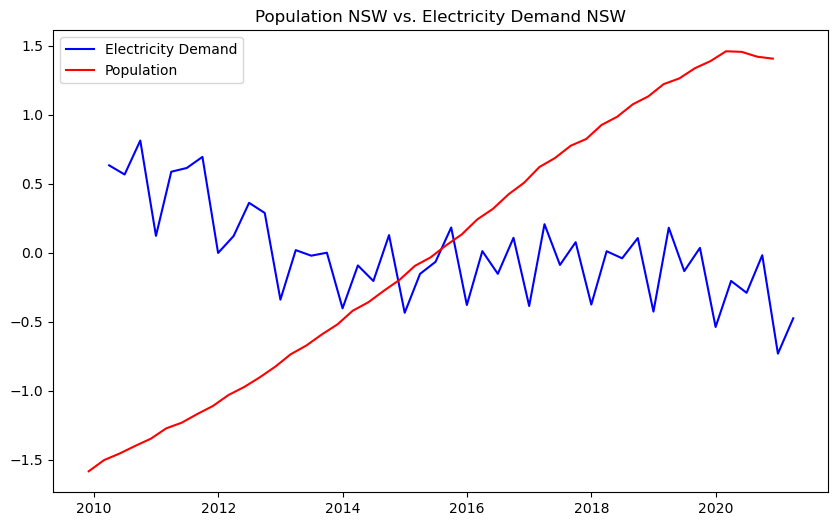

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(df_total_demand_nsw_quarterly['time'], df_total_demand_nsw_quarterly['normalized_demand'], label='Electricity Demand', color='blue')
plt.plot(df_population_nsw['time'], df_population_nsw['normalized_population'], label='Population', color='red')
plt.legend(loc='upper left')
plt.title('Population NSW vs. Electricity Demand NSW')
plt.show()

This is very interesting. As the population grows, we would typically expect electricity demand to rise, assuming individual consumption remains steady. Contrary to this expectation, we observe a decline in electricity demand. This suggests that the per capita electricity demand is decreasing. Possible explanations for this trend might include a relative decrease in personal income against the cost of electricity, prompting individuals to limit usage, or the adoption of alternative energy sources, like residential solar panels, reducing reliance on traditional electricity supplies.

GDP can rougly (if not totally) represent the income of citizens. Let's check GDP trend first.

#### GDP and Demand

In [60]:
df_gdp['time'] = pd.to_datetime(df_gdp['time'], format='%b-%Y')
df_gdp['normalized_gdp'] = (df_gdp['gdp'] - df_gdp['gdp'].mean()) / df_gdp['gdp'].std()

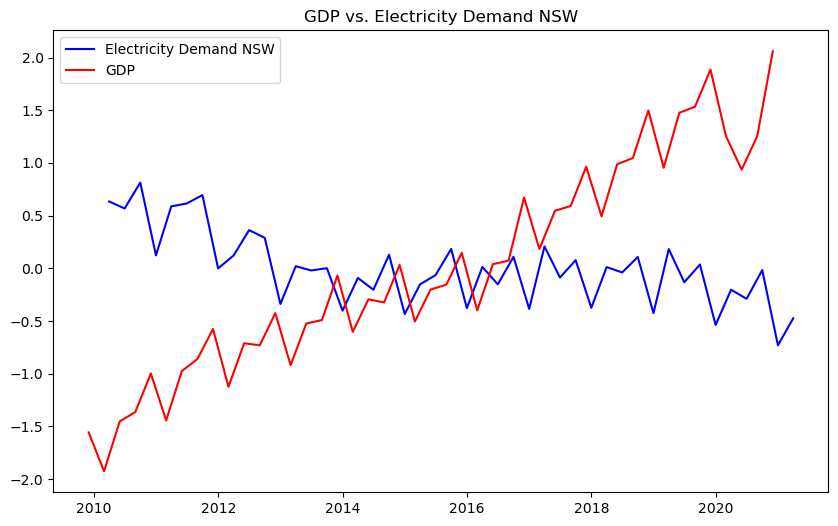

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(df_total_demand_nsw_quarterly['time'], df_total_demand_nsw_quarterly['normalized_demand'], label='Electricity Demand NSW', color='blue')
plt.plot(df_gdp['time'], df_gdp['normalized_gdp'], label='GDP', color='red')
plt.legend(loc='upper left')
plt.title('GDP vs. Electricity Demand NSW')
plt.show()

GDP kept increasing from 2010 to 2020. So could it be that the electricity price increased a lot during that period? 

Based on the information from the CEIC data website regarding electricity prices in New South Wales, it appears that electricity costs did not fluctuate significantly during that time frame. This indicates that the theory of decreasing personal income in relation to the price of electricity might not hold true. 

The increased adoption of residential solar panels might be another factor to consider, as this can lead to a reduction in dependency on conventional electricity grids. As more households install solar panels, the aggregate demand on traditional energy providers is likely to diminish. 

In [66]:
# Read Temperature file
df_temp_vic = pd.read_csv('../data/Australia/temprature_vic.csv')
df_temp_vic.columns = df_temp_vic.columns.str.lower()

In [67]:
# Read totaldemand file
df_demand_vic = pd.read_csv('../data/Australia/totaldemand_vic.csv')
df_demand_vic.columns = df_demand_vic.columns.str.lower()

In [68]:
# Read population file
df_population_vic = pd.read_csv('../data/Australia/population_vic.csv')
df_population_vic.columns = df_population_vic.columns.str.lower()

### First glance at the data

In [69]:
df_temp_vic.head()

,location,datetime,temperature
0,Melbourne (Olympic Park),31/05/2013 15:00,18.2
1,Melbourne (Olympic Park),31/05/2013 15:30,18.3
2,Melbourne (Olympic Park),31/05/2013 16:00,18.3
3,Melbourne (Olympic Park),31/05/2013 16:30,18.3
4,Melbourne (Olympic Park),31/05/2013 17:00,18.2


In [71]:
df_temp_vic['location'].nunique()

1

In [72]:
df_demand_vic.head()

,datetime,totaldemand,regionid
0,2010-01-01 00:00:00,5426.12,VIC1
1,2010-01-01 00:30:00,5111.02,VIC1
2,2010-01-01 01:00:00,4960.03,VIC1
3,2010-01-01 01:30:00,5283.40,VIC1
4,2010-01-01 02:00:00,5046.15,VIC1


In [75]:
df_demand_vic['regionid'].nunique()

1

In [76]:
df_population_vic.head()

,time,population
0,Dec-09,5419249
1,Mar-10,5445172
2,Jun-10,5461101
3,Sep-10,5478710
4,Dec-10,5495711


### Check Correlation between demand and each variables

#### Temperature and Demand

In [85]:
df_demand_vic['time'] = pd.to_datetime(df_demand_vic['datetime'], format='%Y-%m-%d %H:%M') 

In [86]:
df_temp_vic['time'] = pd.to_datetime(df_temp_vic['datetime'], format='%d/%m/%Y %H:%M') 

In [87]:
df_temp_demand_vic = pd.merge(df_temp_vic, df_demand_vic, on='time')

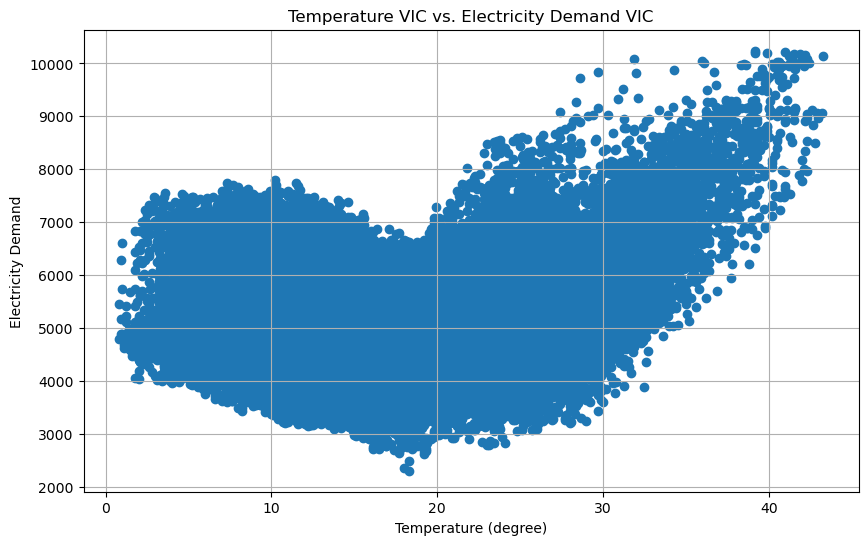

In [99]:
plt.figure(figsize=(10, 6))
plt.scatter(df_temp_demand_vic['temperature'], df_temp_demand_vic['totaldemand'])
plt.title('Temperature VIC vs. Electricity Demand VIC')
plt.xlabel('Temperature (degree)')
plt.ylabel('Electricity Demand')
plt.grid(True)
plt.show()

As depicted in the graph, it resembles a V shape. Below approximately 18 degrees, the demand increases as the temperature decreases; above 18 degrees, the demand rises with increasing temperature. This pattern aligns with our everyday experience. Temperature is useful in our modeling and it is aligned with trend in NSW

#### Population and Demand

In [101]:
df_demand_vic['normalized_demand'] = (df_demand_vic['totaldemand'] - df_demand_vic['totaldemand'].mean()) / df_demand_vic['totaldemand'].std()

In [102]:
df_demand_vic.set_index('time', inplace=True) 
total_demand_vic_quarterly = df_demand_vic['normalized_demand'].resample('Q').mean()
df_total_demand_vic_quarterly = total_demand_vic_quarterly.reset_index()

In [105]:
df_population_vic['time'] = pd.to_datetime(df_population_vic['time'], format='%b-%y')
df_population_vic['normalized_population'] = (df_population_vic['population'] - df_population_vic['population'].mean()) / df_population_vic['population'].std()

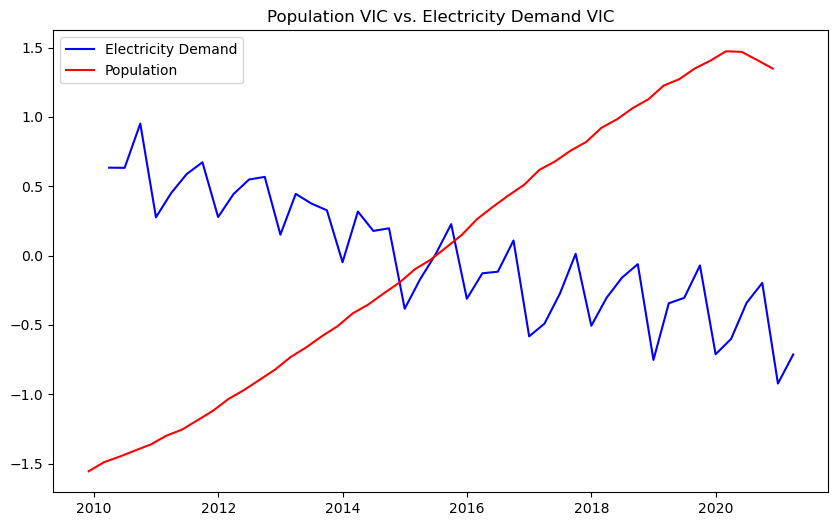

In [106]:
plt.figure(figsize=(10, 6))
plt.plot(df_total_demand_vic_quarterly['time'], df_total_demand_vic_quarterly['normalized_demand'], label='Electricity Demand', color='blue')
plt.plot(df_population_vic['time'], df_population_vic['normalized_population'], label='Population', color='red')
plt.legend(loc='upper left')
plt.title('Population VIC vs. Electricity Demand VIC')
plt.show()

Same trend as NSW

#### GDP and Demand

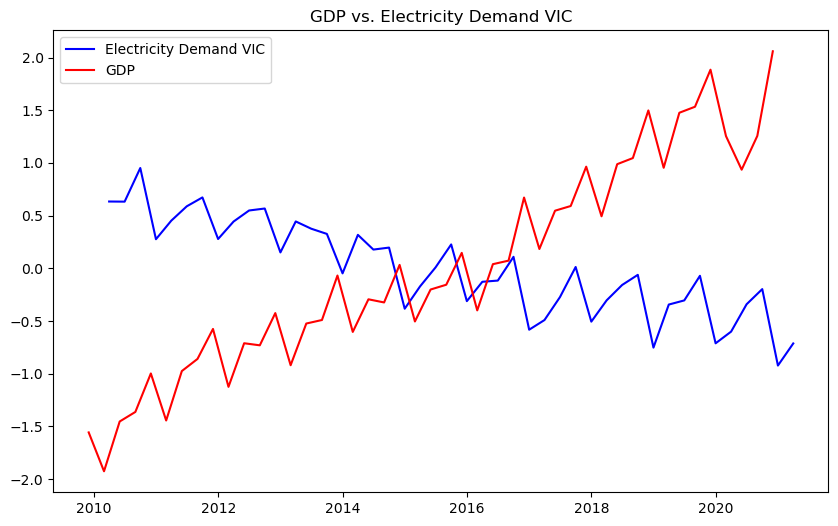

In [107]:
plt.figure(figsize=(10, 6))
plt.plot(df_total_demand_vic_quarterly['time'], df_total_demand_vic_quarterly['normalized_demand'], label='Electricity Demand VIC', color='blue')
plt.plot(df_gdp['time'], df_gdp['normalized_gdp'], label='GDP', color='red')
plt.legend(loc='upper left')
plt.title('GDP vs. Electricity Demand VIC')
plt.show()

Similar trend as NSW